# Implied Volatility Surface Visualizer

This notebook fetches live options data for a given stock and visualizes its implied volatility surface.
It demonstrates Python programming, numerical analysis, and 3D visualization skills.


1) Import Necessary Libraries

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.interpolate import Rbf
from scipy.stats import zscore
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


2) Class Definition

In [14]:
class IVSurface:
    def __init__(self, ticker_symbol):
        self.ticker_symbol = ticker_symbol.upper()
        self.ticker = yf.Ticker(self.ticker_symbol)
        self.spot_price = self._get_spot_price()
        self.options_df = None

    def _get_spot_price(self):
        price = self.ticker.info.get("regularMarketPrice")
        if price is None:
            price = self.ticker.history(period="2d")["Close"].iloc[-1]
        return price

    def fetch_options(self):
        expiries = self.ticker.options
        options_list = []

        for expiry in expiries:
            chain = self.ticker.option_chain(expiry)
            expiry_date = pd.to_datetime(expiry)
            
            for opt_type, df in [('call', chain.calls), ('put', chain.puts)]:
                df = df.copy()
                df["option_type"] = opt_type
                df["expiry"] = expiry_date
                df["moneyness"] = df["strike"] / self.spot_price
                df["ttm"] = (expiry_date - pd.Timestamp.today()).days / 365.25
                df = df[["moneyness", "ttm", "impliedVolatility"]].dropna()
                options_list.append(df)
        
        self.options_df = pd.concat(options_list, ignore_index=True)
        self._clean_data()

    def _clean_data(self):
        # Filter out extreme IVs using z-score
        self.options_df['iv_zscore'] = zscore(self.options_df['impliedVolatility'])
        self.options_df = self.options_df[self.options_df['iv_zscore'].abs() < 3]
        self.options_df.drop(columns='iv_zscore', inplace=True)

        # Filter moneyness and ttm ranges
        self.options_df = self.options_df[
            (self.options_df["moneyness"].between(0.7, 1.3)) &
            (self.options_df["ttm"] > 0.02)
        ]

        # Filter sparse regions
        bins_m = np.linspace(0.7, 1.3, 20)
        bins_t = np.linspace(self.options_df["ttm"].min(), self.options_df["ttm"].max(), 20)
        hist, xedges, yedges = np.histogram2d(self.options_df["moneyness"], self.options_df["ttm"], bins=[bins_m, bins_t])
        mask = hist > 2  # min 3 points per bin
        self.mask_grid = mask
        self.xedges = xedges
        self.yedges = yedges

    def interpolate_surface(self, smooth=0.7):
        rbf = Rbf(
            self.options_df["moneyness"],
            self.options_df["ttm"],
            self.options_df["impliedVolatility"],
            function='multiquadric',
            smooth=smooth
        )

        xi = np.linspace(self.options_df["moneyness"].min(), self.options_df["moneyness"].max(), 100)
        yi = np.linspace(self.options_df["ttm"].min(), self.options_df["ttm"].max(), 100)
        Xi, Yi = np.meshgrid(xi, yi)
        Zi = rbf(Xi, Yi)

        self.Xi, self.Yi, self.Zi = Xi, Yi, Zi

    def plot_surface(self, show_scatter=False, show_contours=False):
        fig = plt.figure(figsize=(12, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Surface
        surf = ax.plot_surface(self.Xi, self.Yi, self.Zi, cmap='viridis', edgecolor='none', alpha=0.9)

        # Optional scatter overlay
        if show_scatter:
            ax.scatter(
                self.options_df["moneyness"],
                self.options_df["ttm"],
                self.options_df["impliedVolatility"],
                color='red', s=10, alpha=0.5, label='Raw Data'
            )

        # Optional contour projection underneath
        if show_contours:
            ax.contour(
                self.Xi, self.Yi, self.Zi, zdir='z', offset=self.Zi.min() - 0.01,
                cmap='viridis', alpha=0.7
            )

        ax.set_xlabel('Moneyness (K/S)')
        ax.set_ylabel('Time to Expiry (Years)')
        ax.set_zlabel('Implied Volatility')
        ax.set_title(f"{self.ticker_symbol} Implied Volatility Surface")
        ax.view_init(elev=25, azim=135)
        fig.colorbar(surf, shrink=0.5, aspect=10, label='Implied Volatility')

        if show_scatter:
            ax.legend()

        plt.tight_layout()
        plt.show()


3) Get the option data for chosen stock

In [16]:
stock = input("Enter your stock ticker: ").upper()
ivs = IVSurface(stock)
ivs.fetch_options()

print(f"Number of option entries after cleaning: {len(ivs.options_df)}")
ivs.options_df.head()


Enter your stock ticker:  AAPL


Number of option entries after cleaning: 933


,moneyness,ttm,impliedVolatility
110,0.702312,0.024641,1.083989
111,0.721294,0.024641,1.013189
112,0.740275,0.024641,0.656253
113,0.759256,0.024641,0.605473
114,0.778238,0.024641,0.660160


4) Interpolate Data

In [18]:
ivs.interpolate_surface(smooth=0.7)

5) Plot 3D surface

Would you like the real data points overlayed on the IV surface? (y/n):  N
Would you like contour lines plotted underneath the IV surface? (y/n):  n


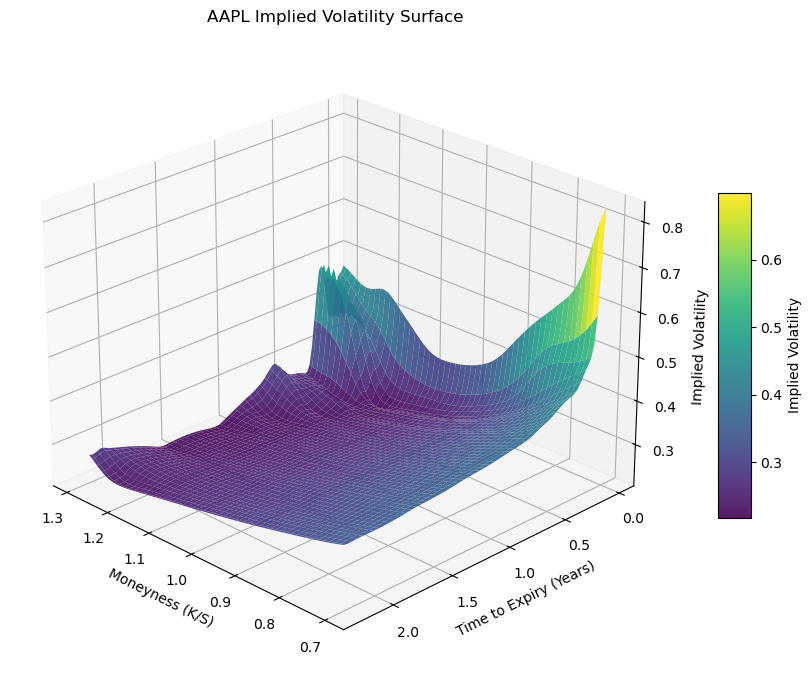

In [24]:
scatter_choice = input("Would you like the real data points overlayed on the IV surface? (y/n): ").strip().lower() == "y"
contours_choice = input("Would you like contour lines plotted underneath the IV surface? (y/n): ").strip().lower() == "y"


ivs.plot_surface(show_scatter=scatter_choice, show_contours=contours_choice)

6) Optional data of ATM IV

In [28]:
n_closest = 5
atm_options = ivs.options_df.iloc[(ivs.options_df['moneyness'] - 1).abs().argsort()[:n_closest]]

# Compute average ATM IV
avg_atm_iv = atm_options['impliedVolatility'].mean()

print(f"ATM options (closest {n_closest}):")
print(atm_options)
print(f"\nAverage ATM IV: {avg_atm_iv:.4f}")

ATM options (closest 5):
     moneyness       ttm  impliedVolatility
189   0.996524  0.024641           0.345832
133   0.996524  0.024641           0.369757
336   1.006015  0.062971           0.291328
973   1.006015  0.484600           0.294197
134   1.006015  0.024641           0.364142

Average ATM IV: 0.3331


7) Conclusion and notes

This notebook demonstrates:
- Fetching and cleaning live options data
- Computing moneyness and time to expiry
- Interpolating the implied volatility surface using RBF
- Optional 3D visualization with scatter, contour projections and ATM IV data